In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import json
import random

from openai import OpenAI
from dotenv import load_dotenv

In [5]:
df = pd.read_csv('faculty_data.csv', encoding='ISO-8859-1')

df = df.rename(columns={'Name': 'name',
                   'School': "school",
                    'Degree Program': "degree_program",
                    'UGA Affiliations (e.g. Centers or Institutes etc.)': "uga_affiliations",
                    'Previous Instutution(s)': "previous_institutions",
                    'PhD. Degree': "phd_degree",
                    'Interdisciplinary Areas': "interdisciplinary_areas",
                    'Broad Speacialty Areas / Expertise': "broad_specialties",
                    'Research Keywords': "research_keywords",
                    'Major Tool / Equipment': "equipment",
                    'Potential Sponsors': "potential_sponsors",
                    'UGA Collaborator(s)': "uga_collaborators",
                    'Outside Collaborator(s)': "outside_collaborators",
                    'Global Engagement': "global_engagement",
                    'Memberships': "memberships",
                    'Other Information': "other"
                })

df['name'] = df['name'].ffill()
df['name'] = df['name'].str.strip()
df = df.groupby('name').agg(lambda x: ', '.join(x.dropna().astype(str)))

def combine_entries(series):
    if series.dtype == 'object':
        return ', '.join(set(', '.join(series.dropna()).split(', ')))
    else:
        return series.dropna().iloc[0]

df = df.groupby('name').agg(combine_entries).reset_index()

gen_df = df[["name", "interdisciplinary_areas", "broad_specialties"]]
json_data = gen_df.to_json(orient="records", indent=4)

print(df.columns)

Index(['name', 'school', 'degree_program', 'uga_affiliations',
       'previous_institutions', 'phd_degree', 'interdisciplinary_areas',
       'broad_specialties', 'research_keywords', 'equipment',
       'potential_sponsors', 'uga_collaborators', 'outside_collaborators',
       'global_engagement', 'memberships', 'Unnamed: 15', 'Other'],
      dtype='object')


In [6]:
load_dotenv()

API_KEY = os.getenv("API_KEY")

client = OpenAI(
  api_key=API_KEY
)

prompt = f"""
You are categorizing engineering professors at the University of Georgia based on their interdisciplinary research areas and broad specialties.  

Your task is to **group them into exactly 4-5 categories** that balance **connectivity and meaningful distinctions** in a network graph. Each professor **must** fit into one of these broader categories, even if their specialty is niche.  

---

### **Rules for Categorization**
1. **Choose exactly 4-5 categories.**  
   - Example possible categories:  
     - "AI, Data Science, and Cyber-Physical Systems"  
     - "Biomedical and Health Engineering"  
     - "Energy, Environment, and Sustainability"  
     - "Materials, Manufacturing, and Robotics"  
     - "Education, Policy, and Social Impact in Engineering"  
   - You may **adjust the categories slightly**, but they must remain **broad and standardized** while keeping research connections meaningful.  

2. **Strict Assignment:**  
   - If a professor's research spans multiple areas, **choose the closest matching category.**  
   - If both fields are empty, assign them `""`.  

3. **No More Than 5 Groups!**  
   - If a category has **only one person**, merge it with a related one.  
   - If a category gets too large, split it only **if necessary**.  
4. Your response MUST follow the expected output format.

---

### **Input JSON Data**
{json_data}

### **Expected Output Format**
{{
    "insight": "<mention if any professors were difficult to categorize>",
    "generated_disciplines": [
        {{
          "name": "<professor_name_1>",
          "discipline": "<one of the 4-5 selected categories>"
        }},
        {{
          "name": "<professor_name_2>",
          "discipline": "<one of the 4-5 selected categories>"
        }},
        ...
    ]
}}
"""

# First prompt (categorization of professors into disciplines)
completion = client.chat.completions.create(
  model="gpt-4o-mini",
  store=True,
  messages=[{
      "role": "user", 
      "content": prompt  # Original categorization prompt
  }]
)

raw_content = completion.choices[0].message.content.strip()

if raw_content.startswith("```json"):
    raw_content = raw_content[7:-3]

data = json.loads(raw_content)
disciplines_df = pd.DataFrame(data["generated_disciplines"])
disciplines_df.set_index("name", inplace=True)
disciplines_df.index = disciplines_df.index.str.strip()


In [7]:
df_json = df.to_json(orient="records", indent=4)

# Update the second_prompt with the data
second_prompt = f"""
You are tasked with categorizing engineering professors at the University of Georgia based on their relatedness to other professors. You will use
the following columns in the data to establish connections:
- **'uga_collaborators'**
- **'outside_collaborators'**
- **'interdisciplinary_areas'**
- **'broad_specialties'**
- **'generated_disciplines'**

Your goal is to **group professors into related clusters** based on shared collaborators, research areas, and disciplines. **You should calculate
connection strength based on shared collaborators or research areas** and assign each connection a weight according to the following principles:
1. **Collaborators**: Professors sharing collaborators within UGA, then outside UGA should have a higher weights in that order.
   - For example, two professors with 3 shared UGA collaborators will have a stronger connection than two with 3 shared outside collaborators, and both
  will have a stronger connection than two with only 1 shared collaborator.
2. **Interdisciplinary Areas**: Professors with overlapping interdisciplinary areas should have a moderate weight.
   - For example, two professors in the "AI, Data Science, and Cyber-Physical Systems" category could be connected with a lower weight if
    they share a similar area.
3. **Disciplines**: Professors who share the same generated discipline from the previous categorization step should be considered highly related.
4. **Weights**: Ensure that the connection weights are rounded to one decimal place (e.g., 3.0, 1.5, etc.).
5. **Justification**: Provide a reasoning breakdown for each weight, specifying which columns contributed to the connection strength.

### Input Data:
{df_json}

Your **output** must ONLY be a JSON, and fit the format as below:
{{
    "insight": "<mention if any professors were difficult to categorize>",
    "generated_groups": [
        {{
          "name": "<professor_name>",
          "related_professors": [
            {{
              "name": "<related_professor_1>", 
              "weight": "<connection_weight>",
              "reasoning": {{
                "uga_collaborators": "<number_of_shared_collaborators>",
                "outside_collaborators": "<number_of_shared_outside_collaborators>",
                "interdisciplinary_areas": "<number_of_shared_areas>",
                "broad_specialties": "<number_of_shared_specialties>",
                "generated_disciplines": "<True/False if same discipline>"
              }}
            }},
            ...
          ]
        }},
        ...
    ]
}}
"""

# Get response for second prompt (relatedness)
completion = client.chat.completions.create(
  model="gpt-4o-mini",
  store=True,
  messages=[{
      "role": "user", 
      "content": second_prompt  # Original categorization prompt
  }]
)
raw_content = completion.choices[0].message.content.strip()

if raw_content.startswith("```json"):
    raw_content = raw_content[7:-3]

relatedness_data = json.loads(raw_content)

# Now create DataFrame
relatedness_df = pd.DataFrame(relatedness_data["generated_groups"])
relatedness_df = relatedness_df.reset_index(drop=True).set_index('name')

# Convert 'related_professors' to a list of tuples (name, weight)
relatedness_df["related_professors"] = relatedness_df["related_professors"].apply(
    lambda x: [(rel["name"], float(rel["weight"])) for rel in x]
)

relatedness_df.index = relatedness_df.index.str.strip()

print(relatedness_df)

                                                       related_professors
name                                                                     
Beiwen Li                        [(Hongyue Sun, 2.6), (Haijian Sun, 2.1)]
Christina Fuller                          [(Felix Santiago Collazo, 1.0)]
Elizabeth J. Brisbois                                      [(He Li, 1.0)]
Felix Santiago Collazo      [(Christina Fuller, 1.0), (Hongyue Sun, 1.5)]
Haijian Sun                                           [(Kenan Song, 1.0)]
Hongyue Sun             [(Felix Santiago Collazo, 1.5), (Lingling Liu,...
He Li                                      [(Elizabeth J. Brisbois, 1.0)]
Lingling Liu               [(Hongyue Sun, 1.0), (Qianwen (Cami) Li, 1.3)]
Qianwen (Cami) Li               [(Lingling Liu, 1.3), (Haijian Sun, 1.0)]
Kenan Song                                           [(Haijian Sun, 1.0)]
James Huff                                          [(Julie Martin, 1.0)]
Julie Martin                          

In [8]:
# Merge the dataframes
df = df.reset_index(drop=True).set_index('name')
df = df.merge(disciplines_df, left_index=True, right_index=True, how="left")
df = df.merge(relatedness_df, left_index=True, right_index=True, how="left")

# Clear all blank strings
# df.replace("", np.nan, inplace=True)

In [9]:
search_professor = True
category_search_parameter = "discipline"
professor_search_parameter = "Beiwen Li"

In [10]:
df

,school,degree_program,uga_affiliations,previous_institutions,phd_degree,interdisciplinary_areas,broad_specialties,research_keywords,equipment,potential_sponsors,uga_collaborators,outside_collaborators,global_engagement,memberships,Unnamed: 15,Other,discipline,related_professors
name,,,,,,,,,,,,,,,,,,
Beiwen Li,ECAM,"Optical Engineering, Mechanical Engineering",IIPA - Institute for Integrative Precision Agr...,Iowa State University,Mechanical Engineering,,In-situ Surface Monitoring of Manufacturing Pr...,"Quality Control thsu optical Imaging, In-situ ...",,"NSF - National Science Foundation, DOE Remade,...","Zhenglu Li (plant breedy), Hongyue Sun","Iowa State University, Purdue, A&M",China,"ASME, Optica, SPIE",,,"Materials, Manufacturing, and Robotics","[(Hongyue Sun, 2.6), (Haijian Sun, 2.1)]"
Christina Fuller,ECAM,Environmental Engineering,,"Harvard University, Georgia State University",Public Health,,Green infrastructure for air pollution control...,"epidemiology, Environmental exposure, Air poll...",Ethy ...,"Others: NIFA,, JPB Foundations, DoT, NSF, NRCS...","Felix Santiago Collazo, Alysha Helmrich, Jenna...","GA Tech, 2B Technologies Inc, GSU, Emory Unive...",CEANA,,,Requests: Brown bag - faculty get together,"Energy, Environment, and Sustainability","[(Felix Santiago Collazo, 1.0)]"
Elizabeth J. Brisbois,CMBE,Chemical Engineering,,"University of Michigan, Concordia University",Chemistry,"bioengineering, chemistry, materials, biology,...","Polymer and Small Molecule Chemistry, Insulin ...","Biocompatibility of Materials, Stimuli Respons...","NO analyzer (Gas Phase), Fluorescent Microscopes","DOD, Current:, Cystic Fibrosis Foundation, NIH...","Ben Brainer (Vet), Vincent Starai (Microbiolog...","Duke, UT Austin., University of Michigan, Bayl...",,"Society of Biomaterials, ACS, BMES",,,Biomedical and Health Engineering,"[(He Li, 1.0)]"
Felix Santiago Collazo,ECAM,"Civil Engineering, Environmental Engineering","RBC - River Basin Center, CICR - Center for In...",Louisiana State University,,,"Mo modeling but also collect data on field., ...","Water equity, Hybrid infrastructure for water ...","River modeling, Flow/ velociy pipe sensors, WM...","Industry, NOAA, NSF, UNESCO","Jacqueline Sanders, Sussana Freida, Iris, Jenn...","Ot , UT Am ., Ec .., FIV","Nicaragua, Mexico, Netherland, Brazil, Cuba","Geophysical Unit, ASFPM, ASCE, AGU",,"NSF Workshop - grant , Support Need: , Supp ....","Energy, Environment, and Sustainability","[(Christina Fuller, 1.0), (Hongyue Sun, 1.5)]"
Haijian Sun,ECE,Electrical Engineering,"CPS, IIPA - Institute for Integrative Precisio...","Utah State, University of Wisconsin",Major Electrical,,"Vehicle Communications, 5G and beyond Wireless...","Vehicle Communications, Wireless Communication...","Wireless Transmitter Devices, , Wireless Signa...","DOE, Delta, DoT, NSF, Sony, DoD","Ramviyas, Jin Ye, Linbing Wang, Jin Sun, Wenzh...","FIU, Augusta, Argonne National, University of ...",,IEEE,,,"AI, Data Science, and Cyber-Physical Systems","[(Kenan Song, 1.0)]"
He Li,CMBE,Biomedical Engineering,IAI - Institute for AI,"Brown University, University of Connecticut",Mechanical Engineering,,"Artificial Intelligence for pathology, Machine...","Blood Disease Modeling, Epidemiology Modeling,...",Software packages - LAMMPS,"NIH, NSF, DoE","XQ Wang, John Drake (ecology)","WPI, U Penn, Yale",,"Biophysics Society, BMES",,,"AI, Data Science, and Cyber-Physical Systems","[(Elizabeth J. Brisbois, 1.0)]"
Hongyue Sun,ECAM,Mechanical Engineering,IIPA - Institute for Integrative Precision Agr...,"Virginia Tech, University at Buffalo",Industrial Engineering,"Electrical Engineering, Industrial Engineering...","Humam Factor / Ergonomic / ?, Artificial Intel...","Ethics in Manufacturing, Healthcare / ...., O...","3d Scanners Robots, 3D Printers, Thermal Camer...","MxD, DOD, NRL, DOE, NIST, NOISH, NSF","Beshoy Morkos, Haijin Sun, Glen Rains, Guoyu L...","Georgia Tech, University at Buffalo, Miami Uni...",,"IEEE, INFORMS, ASME, ASEE"

In [11]:
if not search_professor:
    graphs = {}

    # Identify categories with only one person
    category_counts = df[category_search_parameter].value_counts()
    single_nodes = category_counts[category_counts == 1].index

    # Create an empty "Miscellaneous" category
    miscellaneous = []

    for value in df[category_search_parameter].unique():
        if pd.isna(value) or value == "":  # Skip NaN values and empty strings
            continue
        # Filter dataframe
        subset = df[df[category_search_parameter] == value]

        # If the category has only one person, move them to "Miscellaneous"
        if value in single_nodes:
            miscellaneous.append(subset.index[0])
            continue  # Skip creating a graph for this category

        G = nx.Graph()
        nodes = list(subset.index)
        G.add_nodes_from(nodes)

        # Create a tree (connected graph with no cycles) by adding edges sequentially
        for i in range(1, len(nodes)):
            G.add_edge(nodes[i - 1], nodes[i])  # Connect each node to the previous one

        # Optionally add a cycle or make it a star graph
        if len(nodes) > 3:  # Add a cycle for larger graphs
            cycle_start = random.choice(nodes)
            cycle_end = random.choice(nodes)
            G.add_edge(cycle_start, cycle_end)  # Add a cycle by connecting two random nodes

        # Alternatively, make it a star graph
        if len(nodes) > 4:  # Make it a star graph for larger sets
            center_node = nodes[0]
            for node in nodes[1:]:
                G.add_edge(center_node, node)  # Connect center node to all others to form a star

        graphs[value] = G

    # If there are any "Miscellaneous" nodes, create a graph for them
    if miscellaneous:
        G_misc = nx.Graph()
        G_misc.add_nodes_from(miscellaneous)
        
        # Create a tree for the miscellaneous nodes (connect sequentially)
        for i in range(1, len(miscellaneous)):
            G_misc.add_edge(miscellaneous[i - 1], miscellaneous[i])

        # Add a cycle or make it a star graph for miscellaneous nodes
        if len(miscellaneous) > 3:
            cycle_start = random.choice(miscellaneous)
            cycle_end = random.choice(miscellaneous)
            G_misc.add_edge(cycle_start, cycle_end)

        if len(miscellaneous) > 4:
            center_node = miscellaneous[0]
            for node in miscellaneous[1:]:
                G_misc.add_edge(center_node, node)

        graphs["Miscellaneous"] = G_misc

    # Visualize the graphs
    num_graphs = len(graphs)
    cols = 2  # Number of columns in the grid
    rows = (num_graphs + cols - 1) // cols  # Calculate the required number of rows

    plt.figure(figsize=(cols * 5, rows * 4))  # Adjust figure size dynamically

    for i, (value, G) in enumerate(graphs.items(), 1):
        plt.subplot(rows, cols, i)
        
        # Calculate k for fixed edge length based on the graph size (number of nodes)
        k = 0.2  # Adjust for desired edge length (lower k = shorter edge length)
        
        # Use spring_layout with fixed edge length (adjust k for edge length control)
        pos = nx.spring_layout(G, k=k, seed=42)  # Adjust k for fixed edge length
        
        # Draw the graph with better edge styling
        nx.draw(
            G, pos, with_labels=True, node_color='lightblue', node_size=1500,
            font_size=10, font_weight='normal', edge_color='gray', width=2,
            alpha=0.7, edgecolors="black"
        )

        # Remove bolding on the title for clarity and reduce font size
        plt.title(value, fontsize=12)  # Title with smaller, non-bold font

    plt.tight_layout()
    plt.show()



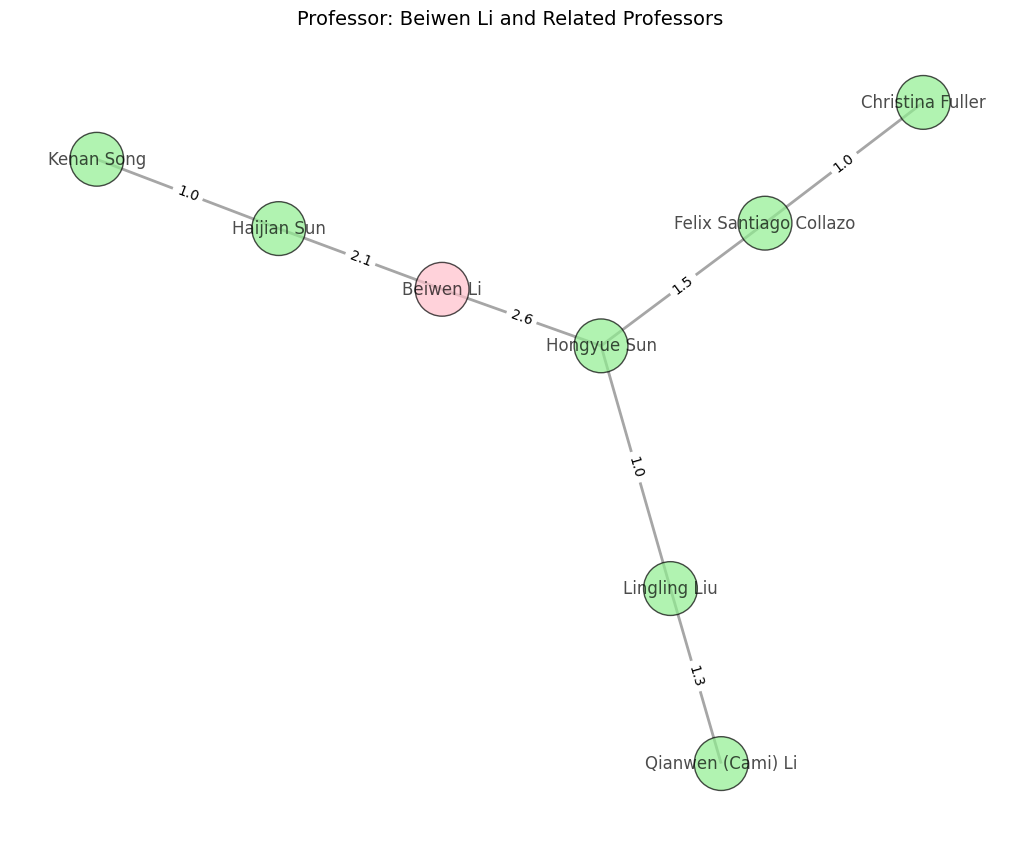

In [16]:
import math

if search_professor:
    # Find the row corresponding to the professor_search_parameter
    professor_data = df[df.index == professor_search_parameter]

    if not professor_data.empty:
        # Extract the professor's related professors and their weights
        related_professors = professor_data['related_professors'].values[0]
        
        # Create a graph for the specific professor and their related professors
        G = nx.Graph()
        
        # Add the initial professor as the first node
        G.add_node(professor_search_parameter)
        
        # Define a set to track all nodes (professors) to avoid duplicates
        added_nodes = {professor_search_parameter}
        
        # Define a set to track which professors we have processed in BFS
        visited = set([professor_search_parameter])
        
        # Perform BFS for 1st, 2nd, and further layers
        layer_queue = [(professor_search_parameter, related_professors)]  # (professor, related_professors)
        
        # For each layer, we'll expand the related professors
        while layer_queue:
            current_layer = layer_queue.pop(0)  # Get the next professor and their related professors
            current_professor, related_professors = current_layer
            
            # Add all related professors from this layer
            for related_professor, weight in related_professors:
                if related_professor not in added_nodes:
                    G.add_node(related_professor)
                    G.add_edge(current_professor, related_professor, weight=weight)
                    added_nodes.add(related_professor)
                    visited.add(related_professor)  # Mark as visited

                    # Add all related professors of the current professor to the queue for the next layer
                    if related_professor in df.index:
                        next_layer_professors = df.loc[related_professor, 'related_professors']

                        if type(next_layer_professors) == 'number':
                            continue

                        # Only add to the queue if this professor hasn't been visited already
                        for next_related_professor, _ in next_layer_professors:                            
                            if next_related_professor not in visited:
                                layer_queue.append((related_professor, next_layer_professors))

        # Visualize the graph
        plt.figure(figsize=(10, 8))

        # Calculate k for fixed edge length based on the graph size (number of nodes)
        k = 0.3  # Adjust for desired edge length (lower k = shorter edge length)
        
        # Use spring_layout with fixed edge length
        pos = nx.spring_layout(G, k=k, seed=42)

        node_colors = ["pink" if node == professor_search_parameter else "lightgreen" for node in G.nodes]

        # Draw the graph with better edge styling
        nx.draw(
            G, pos, with_labels=True, node_color=node_colors, node_size=1500,
            font_size=12, font_weight='normal', edge_color='gray', width=2,
            alpha=0.7, edgecolors="black"
        )
        
        # Draw the edge labels (weights)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

        # Title with the professor's name
        plt.title(f"Professor: {professor_search_parameter} and Related Professors", fontsize=14)
        
        # Adjust layout and remove tight_layout to avoid the warning
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
        plt.show()

    else:
        print(f"Professor '{professor_search_parameter}' not found in the dataset.")
